# Operating on UTKFace Dataset:

The data used here is 'UTKFace Dataset' which has total 23708 images; details of the data are mentioned in the cells to follow.
The purpose of max pooling layer is to carry out pooling operation that calculates the maximum or largest value in each patch of each feature map. The results down sampled or pooled feature maps that highlight the most present feature in the patch.
Firstly, the images are extracted on the basis of gender and moved to folders named train and test - each containing the folders: male and female.
Images are generated from the directory and the model is trained.
Here the model is trained and an accuracy of >90% is obtained.
The trained model is verified with images which is not contained in the train or test dataset.
This saved model can further be used with Open CV to detect face in real time.

In [1]:
import tensorflow as tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import cv2
import shutil

In [2]:
print(tensorflow.__version__)

2.5.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Dataset

In [4]:
!cp '/content/drive/MyDrive/Colab Notebooks/Object_Detection_Open_CV/UTKFaceDS_As_Ed/UTKFace.tar.gz' '/content/' 

In [5]:
shutil.unpack_archive('/content/UTKFace.tar.gz', '/content')

# Information on the nomenclature of labels:


The label of each face image is embedded in the file name, formated: [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age.

[gender] is either 0 (male) or 1 (female).

[race] is an integer from 0 to 4 denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern). 

[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was added to the UTKFace dataset.

In [6]:
# Define and Create directories
imagesdir = os.path.abspath('/content/UTKFace')
traindir=os.path.abspath('/content/train')
testdir=os.path.abspath('/content/test')

if not os.path.exists(traindir):
  os.makedirs(traindir)
if not os.path.exists(testdir):
  os.makedirs(testdir)

train_male_dir=os.path.join(traindir,'male')
if not os.path.exists(train_male_dir):
  os.makedirs(train_male_dir)

test_male_dir=os.path.join(testdir,'male')
if not os.path.exists(test_male_dir):
  os.makedirs(test_male_dir)

train_female_dir=os.path.join(traindir,'female')
if not os.path.exists(train_female_dir):
  os.makedirs(train_female_dir)

test_female_dir=os.path.join(testdir,'female')
if not os.path.exists(test_female_dir):
  os.makedirs(test_female_dir)

print(imagesdir, '\n',traindir,'\n', testdir,'\n', train_male_dir,'\n', train_female_dir,'\n', 
      test_male_dir,'\n', test_female_dir)

/content/UTKFace 
 /content/train 
 /content/test 
 /content/train/male 
 /content/train/female 
 /content/test/male 
 /content/test/female


In [7]:
imagelist = os.listdir(imagesdir)
print('Total images:',len(imagelist), '...first image:', imagelist[0])

Total images: 23708 ...first image: 46_1_3_20170119204838888.jpg.chip.jpg


In [1]:
# Moving images from UTKFace to train_male and train_female directories:

In [8]:
i = 0
moved = 0
for image in imagelist:
    i += 1
    gender = int(image.split('_')[1])
    if gender == 1:
        shutil.move(os.path.join(imagesdir, image), train_male_dir)
    else:
        shutil.move(os.path.join(imagesdir, image), train_female_dir)
    if i >= 1000:
        moved += i
        print(moved, end=' ')
        i = 0

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 

In [2]:
# Moving a given proportion of images from train to respective test directory randomly:

In [9]:
test_pcnt = 0.2
male_images = os.listdir(train_male_dir)
female_images = os.listdir(train_female_dir)
print()
print('Male images:',len(male_images), '  Female images:', len(female_images))


Male images: 11317   Female images: 12391


In [10]:
import random
# Male Images
random_list = random.sample(range(0, len(male_images)), int(len(male_images)*test_pcnt))
male_images_test = [male_images[i] for i in random_list]
i = 0
moved = 0
print("Male images moved to test:", end = ' ')
for image in male_images_test:
    i += 1
    shutil.move(os.path.join(train_male_dir, image), test_male_dir)
    if i >= 1000:
        moved += i
        print(moved, end=' ')
        i = 0

# Female Images
random_list = random.sample(range(0, len(female_images)), int(len(female_images)*test_pcnt))
female_images_test = [female_images[i] for i in random_list]
i = 0
moved = 0
print()
print("Female images moved to test:", end = ' ')
for image in female_images_test:
    i += 1
    shutil.move(os.path.join(train_female_dir, image), test_female_dir)
    if i >= 1000:
        moved += i
        print(moved, end=' ')
        i = 0

Male images moved to test: 1000 2000 
Female images moved to test: 1000 2000 

In [11]:
batch_size=20
img_width = 48
img_height = 48


In [12]:
train_datagen=ImageDataGenerator ( rescale=1. /255,shear_range =0.2,zoom_range=0.2,horizontal_flip =True)
test_datagen=ImageDataGenerator (rescale=1. /255)


train_generator =train_datagen.flow_from_directory(traindir,target_size =(img_width,img_height), batch_size=batch_size,class_mode='binary',classes=['male','female'])
validation_generator =test_datagen.flow_from_directory(testdir,target_size =(img_width,img_height), batch_size=batch_size,class_mode='binary',classes=['male','female'])

Found 18967 images belonging to 2 classes.
Found 4741 images belonging to 2 classes.


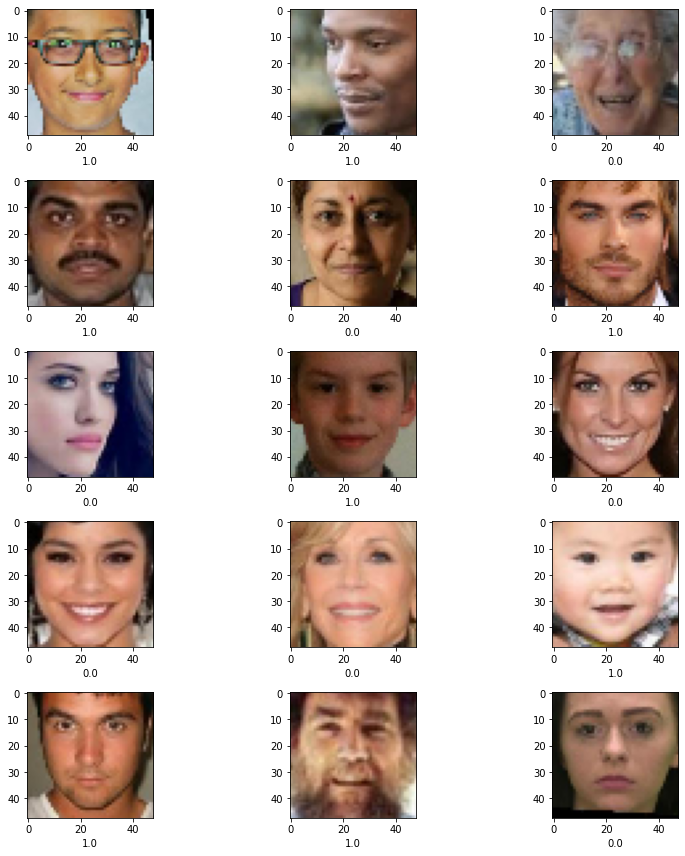

In [13]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.xlabel(str(Y_batch[0]))
        break
plt.tight_layout()
plt.show()

In [14]:
def my_model():
    model = Sequential()
    input_shape = (48,48,3)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling will reduce the size to 24x24x64

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling will reduce the size to 12x12x128

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling will reduce the size to 6x6x256

    model.add(Flatten())#Converts multi dimensional array to 1D channel
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(0.2)) #Used to prevent a model from overfitting
    model.add(Activation('relu')) #relu activation function added to remove the negative values
    model.add(Dropout(0.2)) #Used to prevent a model from overfitting
    model.add(Dense(1)) #output layer
    model.add(Activation('sigmoid')) #sigmoid activation function
    
    
    model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='Adam')
    
    return model

In [15]:
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [16]:
epochs=50
nb_train_sample =500
nb_validation_samples =150

In [17]:
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-2) # set the learning rate
# fit the model
training=model.fit_generator(train_generator,steps_per_epoch=nb_train_sample,epochs=epochs,validation_data=validation_generator,validation_steps=nb_validation_samples)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
500/500 [==============================] - 713s 1s/step - loss: 0.6250 - accuracy: 0.6655 - val_loss: 0.5976 - val_accuracy: 0.6727
Epoch 2/50
500/500 [==============================] - 649s 1s/step - loss: 0.4964 - accuracy: 0.7596 - val_loss: 0.4167 - val_accuracy: 0.7993
Epoch 3/50
500/500 [==============================] - 642s 1s/step - loss: 0.4284 - accuracy: 0.8001 - val_loss: 0.3892 - val_accuracy: 0.8220
Epoch 4/50
500/500 [==============================] - 636s 1s/step - loss: 0.3938 - accuracy: 0.8176 - val_loss: 0.3397 - val_accuracy: 0.8497
Epoch 5/50
500/500 [==============================] - 738s 1s/step - loss: 0.3685 - accuracy: 0.8320 - val_loss: 0.3609 - val_accuracy: 0.8310
Epoch 6/50
500/500 [==============================] - 655s 1s/step - loss: 0.3533 - accuracy: 0.8406 - val_loss: 0.3636 - val_accuracy: 0.8400
Epoch 7/50
500/500 [==============================] - 629s 1s/step - loss: 0.3537 - accuracy: 0.8426 - val_loss: 0.3155 - val_accuracy: 0.8543

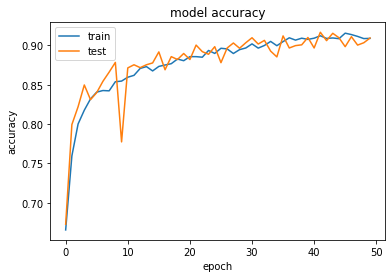

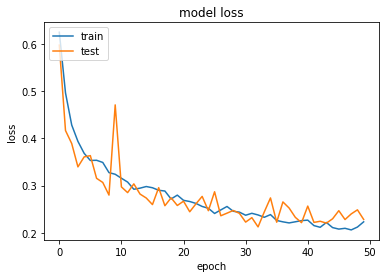

In [18]:
# summarize training for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize traning for loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model.save('/content/drive/MyDrive/Colab Notebooks/Object_Detection_Open_CV/UTKFaceDS_As_Ed/GenderDetectionModel_15_06.h5')

In [20]:
Gender = ('Male', 'Female')

In [35]:
def predict_image_from_file(model, imagefilepath):
    img = tensorflow.keras.preprocessing.image.load_img(imagefilepath,color_mode='rgb',target_size=(48,48))
    show_img=tensorflow.keras.preprocessing.image.load_img(imagefilepath, color_mode='rgb',
                                                           target_size=(200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x /= 255
    custom = model.predict(x)
    
    # x = np.array(x, 'float32')
    # x = x.reshape([48, 48]);

    plt.gray()
    plt.imshow(show_img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    if custom[0][0]>0.5:
      print('Gender Prediction  = Male')
      print("Gender Probability: ",custom[0][0])
    else:
      print('Gender Prediction  = Female')
      print("Gender Probability: ",custom[0][0])
    return custom[0][0]

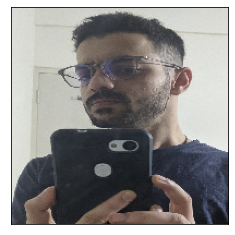

Gender Prediction  = Male
Gender Probability:  0.66926336


In [43]:
imagefilepath = ('/content/drive/MyDrive/Colab Notebooks/Picture.jpg')
res_pred=predict_image_from_file(model, imagefilepath)

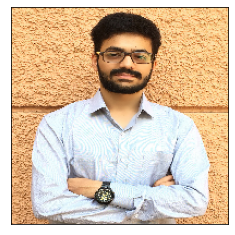

Gender Prediction  = Male
Gender Probability:  0.9947057


In [44]:
imagefilepath = ('/content/drive/MyDrive/Colab Notebooks/Picture_2.JPG')
res_pred=predict_image_from_file(model, imagefilepath)

In [46]:
import cv2

In [47]:
cap=cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    #Capture Frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        print("Can't receive frame (stream end?). Exiting...")
        break
        
#     gray=cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
    
    cv.imshow('frame',frame)
    
    
    if cv.waitKey(1)==ord('q'):
        cv.imwrite("/image.jpg", frame)
        cap.release()
        cv.destroyAllWindows()
        break
        

Cannot open camera
Can't receive frame (stream end?). Exiting...
